In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'
os.environ["PYSPARK_SUBMIT_ARGS"]='--num-executors 5 --executor-memory 4g --executor-cores 1 --driver-memory 2g pyspark-shell'

spark_home = os.environ.get('SPARK_HOME', None)

sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))

In [3]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf()
conf.set("spark.app.name", "Sergey Grishaev ML app") 

spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
from IPython.display import Image

## Pipeline

+ **DataFrame**: ML API использует DataFrame из Spark SQL как dataset, в котором могут храниться признаки, метки классов, предсказания.


+ **Transformer**: Transformer это алгоритм, который может преобразовать один DataFrame в другой DataFrame. Например, ML model это Transformer, который преобразовывает DataFrame с признаками в другой DataFrame с предсказаниями.


+ **Estimator**: Estimator это алгоритм, который может быть обучен на DataFrame, чтобы создать Transformer. Например, алгоритм обучения это - Estimator, который обучается на DataFrame и создает модель.


+ **Pipeline**: Pipeline соединяет в цепочку несколько Transformers и Estimators вместе, чтобы задать ML workflow.


+ **Parameter**: Все Transformers и Estimators теперь имеют общее API для спецификации параметров.

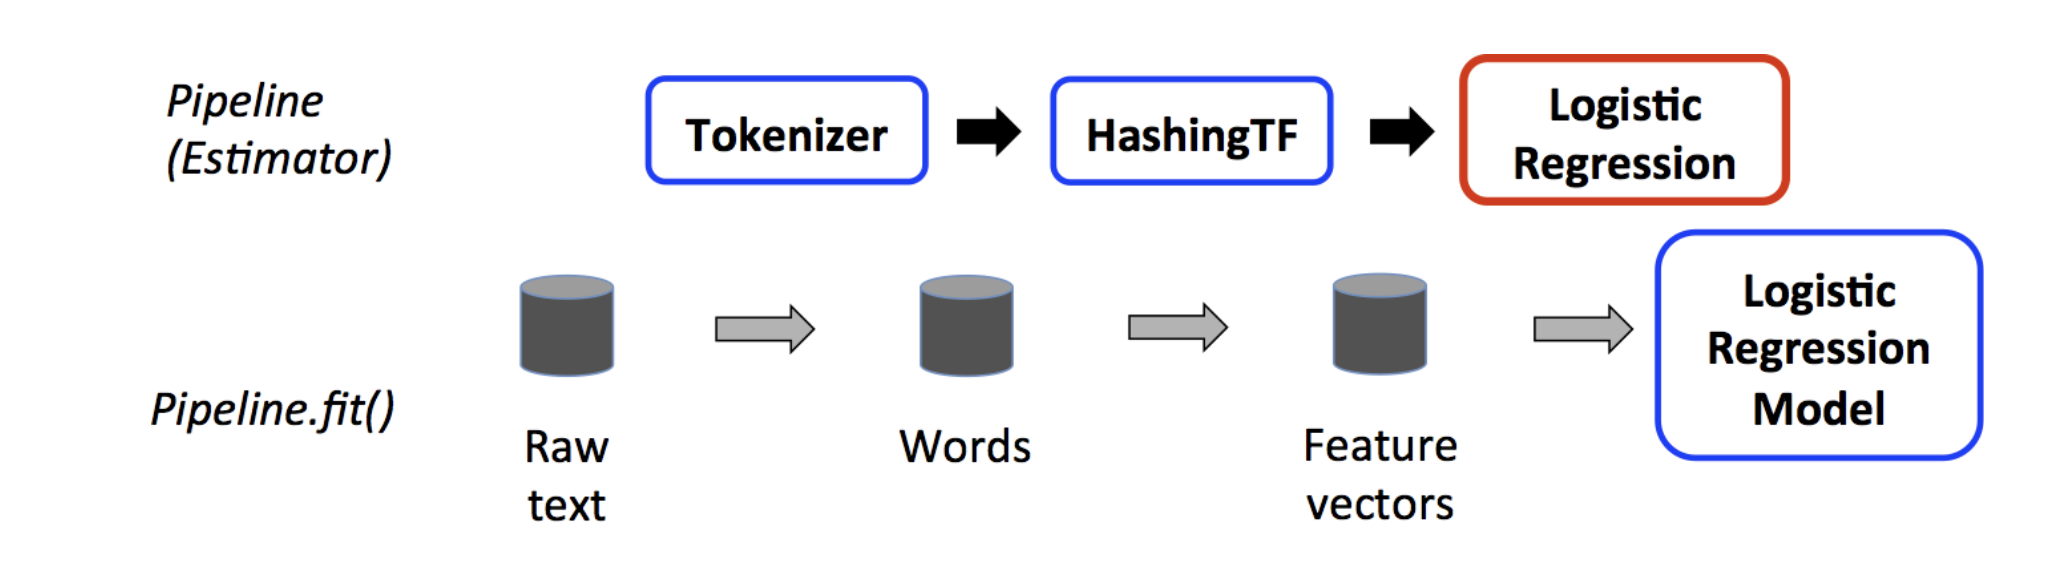

In [5]:
Image("pics/ml-Pipeline.png")

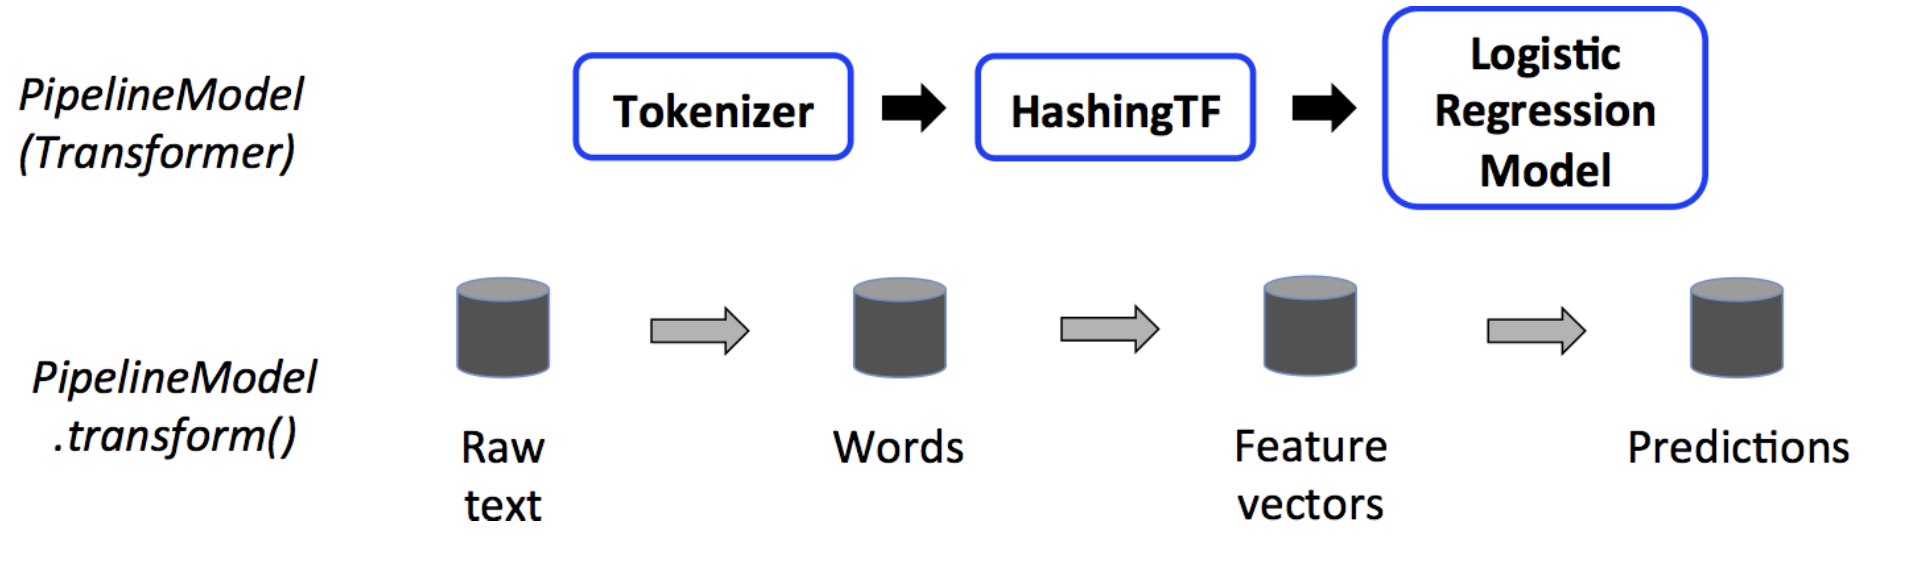

In [6]:
Image("pics/ml-PipelineModel.png")

In [7]:
from pyspark.ml.linalg import Vectors

In [8]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
training_set = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, -1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, -0.5]))], schema = ["label", "features"])

In [ ]:
training_set.printSchema()

In [9]:
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.linalg import VectorUDT

In [ ]:
schema = StructType(fields=[
    StructField("label", DoubleType()),
    StructField("features", VectorUDT()),
])

In [ ]:
training_set = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, -1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, -0.5]))], schema=schema)

In [ ]:
training_set.printSchema()

In [ ]:
lr = LogisticRegression(maxIter=10, regParam=0.01)

In [ ]:
lr

In [ ]:
lr.params

# Что за регуляризационный параметр тут используется?

In [ ]:
lr.getOrDefault("featuresCol")

In [ ]:
lr.getOrDefault("standardization")

In [ ]:
model = lr.fit(training_set)

In [ ]:
type(model)

In [ ]:
dir(model)

In [ ]:
model.summary.predictions.show()

In [ ]:
dir(model.summary)

In [ ]:
model.coefficients

In [ ]:
model.interceptVector

In [ ]:
predict = model.transform(training_set)

In [ ]:
predict.printSchema()

In [ ]:
training_set.show(1)

In [ ]:
predict.show(1, truncate=False, vertical=True)

In [ ]:
model.getOrDefault("threshold")

## Toxic Comment Classification Challenge

In [10]:
from pyspark.sql.types import StringType, IntegerType

In [11]:
schema = StructType([
    StructField("id", StringType()),
    StructField("comment_text", StringType()),
    StructField("toxic", IntegerType()),
    StructField("severe_toxic", IntegerType()),
    StructField("obscene", IntegerType()),
    StructField("threat", IntegerType()),
    StructField("insult", IntegerType()),
    StructField("identity_hate", IntegerType())
])

In [ ]:
! hdfs dfs -head /lectures/lecture03/data/train.csv

In [12]:
dataset = spark.read.csv("/lectures/lecture03/data/train.csv", schema=schema, header=True)

In [ ]:
dataset.show(2, vertical=True)

## Был баг с multiline CSVs, fix в  2.2.0 https://issues.apache.org/jira/browse/SPARK-19610

In [ ]:
dataset = spark.read.csv("/lectures/lecture03/data/train.csv",
                         schema=schema, header=True, multiLine=True)

In [ ]:
dataset.show(2, vertical=True)

In [ ]:
dataset.select("id").show(10)

## Необходимо добавить `escape` параметр!

In [13]:
dataset = spark.read.csv("/lectures/lecture03/data/train.csv",
                         schema=schema, header=True, multiLine=True, escape='"')

In [ ]:
dataset.select("id").show(20)

In [ ]:
dataset.show(2, vertical=True, truncate=False)

In [ ]:
dataset.rdd.getNumPartitions()

In [ ]:
dataset.count()

In [14]:
dataset = dataset.repartition(10)

## Определим бинарный target (toxic/non-toxic)

In [15]:
from pyspark.sql import functions as f

In [16]:
target = f.when(
    (dataset.toxic == 0) &
    (dataset.severe_toxic == 0) &
    (dataset.obscene == 0) &
    (dataset.threat == 0) &
    (dataset.insult == 0) &
    (dataset.identity_hate == 0),
    0
).otherwise(1)

In [17]:
dataset = dataset.withColumn("target", target)

In [ ]:
dataset.select("id", "target").show(20)

In [ ]:
dataset.filter(f.col("id") == "de3c112d4f18ca80").show(2, vertical=True, truncate=False)

In [ ]:
dataset.groupBy("target").count().collect()

In [ ]:
16225 / (16225 + 143346)

In [ ]:
dataset = dataset.drop("toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate").cache()

In [ ]:
dataset.count()

In [ ]:
dataset.show(2, False, True)

In [ ]:
dataset.write.parquet("/tmp/sergey.grishaev_2/comments_dataset_tmp", mode="overwrite")

In [ ]:
!hadoop dfs -ls /tmp/sergey.grishaev_2/comments_dataset_tmp

## Обучим самую простую binary logistic regression

In [18]:
from pyspark.ml.feature import Tokenizer, HashingTF

## Преобразуем комметарии в слова

In [19]:
tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")

In [20]:
dataset2 = tokenizer.transform(dataset)

In [21]:
dataset2

DataFrame[id: string, comment_text: string, toxic: int, severe_toxic: int, obscene: int, threat: int, insult: int, identity_hate: int, target: int, words: array<string>]

In [ ]:
dataset2.select("id", "words").show(2, False, True)

In [ ]:
dataset2.take(1)

In [ ]:
type(dataset2.take(1))

In [ ]:
type(dataset2.take(1)[0])

In [ ]:
type(dataset2.take(1)[0].id)

In [ ]:
type(dataset2.take(1)[0].words)

In [ ]:
dataset2.take(1)[0].words

# Hashing trick vs CountVectorizer

In [ ]:
df = spark.createDataFrame([
    (0, "PYTHON HIVE HIVE".split(" ")),
    (1, "JAVA JAVA SQL".split(" "))
], ["id", "words"])
df.show(truncate = False)

In [ ]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="words", outputCol="features")
model = cv.fit(df)
result = model.transform(df)
result.show(truncate=False)

In [ ]:
from pyspark.ml.feature import HashingTF
ht = HashingTF(inputCol="words", outputCol="features", numFeatures=4)
result = ht.transform(df)
result.show(truncate=False)

In [ ]:
from pyspark.ml.feature import HashingTF
ht = HashingTF(inputCol="words", outputCol="features", numFeatures=20)
result = ht.transform(df)
result.show(truncate=False)

## Преобразуем тексты в бинарные вектора, используя hashing trick

In [22]:
hasher = HashingTF(numFeatures=100, binary=True, inputCol=tokenizer.getOutputCol(), outputCol="word_vector")

In [23]:
dataset2 = hasher.transform(dataset2)

In [24]:
dataset2.select("id", "word_vector").show(2, False, True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id          | 9dabcd2c23f308e2                                                                                                                                                                                      
 word_vector | (100,[0,10,11,14,16,21,22,25,30,35,36,43,49,53,63,64,65,66,70,72,76,77,81,88,91,95,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) 
-RECORD 1------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id          | ff3eea4b51e54a8c                                                                                                                 

In [25]:
hasher_freq = HashingTF(numFeatures=100, binary=False, inputCol=tokenizer.getOutputCol(), outputCol="word_vector_freq")
dataset2_freq = hasher_freq.transform(dataset2)

In [26]:
dataset2_freq.select("id", "word_vector_freq").show(2, False, True)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id               | 9dabcd2c23f308e2                                                                                                                                                                                      
 word_vector_freq | (100,[0,10,11,14,16,21,22,25,30,35,36,43,49,53,63,64,65,66,70,72,76,77,81,88,91,95,99],[1.0,2.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) 
-RECORD 1-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id               | ff3eea4b51e54a8c                                                                                        

## Разобъем наши данные на train и test, не забывая о том, что классы не сбалансированные

In [ ]:
dataset2.show()

In [27]:
train = dataset2.sampleBy("target", fractions={0: 0.8, 1: 0.8}, seed=5757)

In [ ]:
train.groupby("target").count().collect()

In [ ]:
13028 / (13028 + 115017)

In [28]:
test = dataset2.join(train, on="id", how="leftanti")

In [ ]:
test.groupby("target").count().collect()

In [ ]:
3197 / (3197 + 28329)

In [ ]:
train.rdd.getNumPartitions()

In [ ]:
test.rdd.getNumPartitions()

In [ ]:
train

In [34]:
train = train.drop("comment_text", "words")

In [35]:
test = test.drop("comment_text", "words").coalesce(10)

## Обучим logistic regression

In [31]:
from pyspark.ml.classification import LogisticRegression

In [32]:
lr = LogisticRegression(featuresCol=hasher.getOutputCol(), labelCol="target", maxIter=15)

In [ ]:
lr

In [36]:
lr_model = lr.fit(train)

Py4JJavaError: An error occurred while calling o208.fit.
: java.lang.IllegalStateException: SparkContext has been shutdown
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2053)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1143)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1137)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1206)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1182)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:520)
	at org.apache.spark.ml.classification.LogisticRegression$$anonfun$train$1.apply(LogisticRegression.scala:494)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:494)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:489)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:279)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)


In [ ]:
lr_model


In [ ]:
predictions = lr_model.transform(test)

In [ ]:
predictions

In [ ]:
predictions.select("id", "target", "prediction", "probability", "rawPrediction").show(5, False, True)

In [ ]:
correct_predictions = predictions.select("target", f.col("prediction").cast("int")).filter("target == prediction").count()

correct_predictions

In [ ]:
all_predictions = predictions.count()

all_predictions

In [ ]:
print("Accuracy is {}".format(correct_predictions / all_predictions))

In [ ]:
predictions.select("target", f.col("prediction").cast("int"))\
           .filter((f.col("target") == 1) & (f.col("prediction") == f.col("target")))\
           .count()

In [ ]:
predictions_pd = predictions.select("target", f.col("prediction").cast("int")).toPandas()

In [ ]:
predictions_pd.head()

In [ ]:
lr.getOrDefault("threshold")

In [ ]:
from sklearn.metrics import classification_report, precision_score

In [ ]:
print(classification_report(predictions_pd.target, predictions_pd.prediction))

## Что, если мы хотим более надежные метрики?

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="target", metricName='areaUnderROC')

In [ ]:
predictions.show(4)

In [ ]:
evaluator.evaluate(predictions)

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="target", metricName='areaUnderROC')

In [ ]:
evaluator.evaluate(predictions)

In [ ]:
evaluator.setParams(metricName="precision")

In [ ]:
evaluator.evaluate(predictions)

## `spark.ml.evaluation.BinaryClassificationEvaluator` подсчитывает только ROC AUC и PR AUC. Что, если мы хотим больше?

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="f1")

In [ ]:
evaluator.evaluate(predictions)

In [ ]:
evaluator = evaluator.setMetricName("weightedPrecision")

In [ ]:
evaluator.evaluate(predictions)

In [ ]:
evaluator = evaluator.setMetricName("weightedRecall")

In [ ]:
evaluator.evaluate(predictions)

## Определим pipeline!

In [ ]:
dataset = spark.read.parquet("/lectures/lecture03/data/dataset")

In [ ]:
hasher = HashingTF(numFeatures=100, binary=True, inputCol=tokenizer.getOutputCol(), outputCol="word_vector")

In [ ]:
dataset

In [ ]:
dataset.rdd.getNumPartitions()

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
pipeline = Pipeline(stages=[
    tokenizer,
    hasher,
    lr
])

In [ ]:
train = dataset.sampleBy("target", fractions={0: 0.8, 1: 0.8}, seed=42).cache()

In [ ]:
test = dataset.join(train, on="id", how="leftanti").coalesce(10).cache()

In [ ]:
pipeline_model = pipeline.fit(train)

In [ ]:
pipeline_model

In [ ]:
predictions = pipeline_model.transform(test)

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="target", metricName='areaUnderROC')

In [ ]:
evaluator.evaluate(predictions)

## Добавим фичей

In [ ]:
pipeline_model.stages

In [ ]:
pipeline_model = pipeline.fit(train, params={hasher.numFeatures: 200})

In [ ]:
pipeline_model.stages[1].extractParamMap()

In [ ]:
predictions = pipeline_model.transform(test)

In [ ]:
evaluator.evaluate(predictions)

## Больше фичей!

In [ ]:
hasher = HashingTF(numFeatures=200, binary=True, inputCol=tokenizer.getOutputCol(), outputCol="word_vector")

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
import pyspark.sql.functions as f

In [ ]:
dataset.printSchema()

In [ ]:
dataset = dataset.withColumn("comment_length", f.length(dataset.comment_text))

In [ ]:
train = dataset.sampleBy("target", fractions={0: 0.8, 1: 0.8}, seed=42).cache()
test = dataset.join(train, on="id", how="leftanti").coalesce(10).cache()

In [ ]:
train

In [ ]:
assembler = VectorAssembler(inputCols=[hasher.getOutputCol(), "comment_length"], outputCol="features")

In [ ]:
pipeline = Pipeline(stages=[
    tokenizer,
    hasher,
    assembler,
    lr
])

In [ ]:
pipeline_model = pipeline.fit(train)

In [ ]:
pipeline_model.stages

In [ ]:
predictions = pipeline_model.transform(test)

In [ ]:
evaluator.evaluate(predictions)

In [ ]:
predictions.show()

In [ ]:
pipeline_model.stages[-1].coefficients[-1]

## Ok, так как было правильно!? https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52557

## В любом случае, у нас еще не иссякли идеи)

In [ ]:
from pyspark.ml.feature import CountVectorizer

In [ ]:
count_vectorizer = CountVectorizer(inputCol=tokenizer.getOutputCol(), outputCol="word_vector", binary=True)

In [ ]:
count_vectorizer.params

In [ ]:
assembler = VectorAssembler(inputCols=[count_vectorizer.getOutputCol(), "comment_length"], outputCol="features")

In [ ]:
pipeline = Pipeline(stages=[
    tokenizer,
    count_vectorizer,
    assembler,
    lr
])

In [ ]:
lr.getOrDefault("regParam")

In [ ]:
pipeline_model = pipeline.fit(train)

In [ ]:
predictions = pipeline_model.transform(test)
evaluator.evaluate(predictions)

## Hyperparameter tuning

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
paramGrid = ParamGridBuilder().addGrid(lr.maxIter, [15, 20])\
                              .addGrid(lr.regParam, [0.01, 0.05])\
                              .build()

In [ ]:
paramGrid

In [ ]:
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid,
                              evaluator=evaluator, numFolds=3, parallelism=5)

In [ ]:
cv_model = crossval.fit(train)

In [ ]:
cv_model.avgMetrics

In [ ]:
cv_model.bestModel

In [ ]:
predictions = cv_model.transform(test)

In [ ]:
evaluator.evaluate(predictions)

# Попробуем более сложные модели

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol=hasher.getOutputCol(), labelCol="target")

pipeline = Pipeline(stages=[
    tokenizer,
    hasher,
    assembler,
    gbt
])

pipeline_model = pipeline.fit(train)

predictions = pipeline_model.transform(test)

evaluator.evaluate(predictions)

In [ ]:
paramGrid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 15])\
                              .addGrid(gbt.maxDepth, [7, 9])\
                              .addGrid(gbt.stepSize, [0.2, 0.25])\
                              .build()

In [ ]:
paramGrid

In [ ]:
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid,
                              evaluator=evaluator, numFolds=3, parallelism=3)

In [ ]:
cv_model = crossval.fit(train)

In [ ]:
cv_model.avgMetrics

In [ ]:
cv_model.bestModel

In [ ]:
predictions = cv_model.transform(test)

In [ ]:
evaluator.evaluate(predictions)

In [ ]:
spark.stop()

### https://spark.apache.org/docs/2.4.6/ml-features.html